In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from matplotlib import pyplot as plt
from sklearn.calibration import cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
df=pd.read_pickle('.\\data\\cleaned_std_df.pkl')
df_pca=pd.read_pickle('.\\data\\pca4_df.pkl')

In [3]:
df_pca.head()

,PC1,PC2,PC3,PC4,diagnosis
0,2.936476,-3.669310,-1.051714,-0.980591,1
1,6.224017,-0.910183,-0.491957,-1.431165,1
2,4.116492,-1.871431,-0.546454,-3.780266,1
3,3.162500,4.443138,-2.275751,0.445805,1
4,2.990830,-2.415266,-1.150427,0.397565,1


In [4]:
y=df_pca['diagnosis']
X=df_pca.drop('diagnosis', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
{'Train Recall': 0.9173553719008265, 'Test Recall': 0.9038461538461539, 'Test F1 Score': 0.9400000000000001}
Confusion Matrix:
[[101   1]
 [  5  47]]


c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


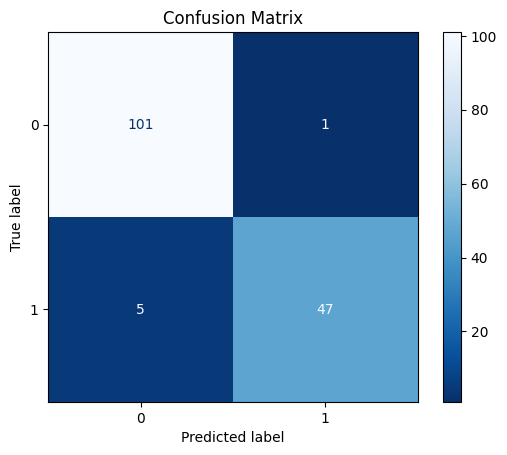

In [5]:
#baseline
eval={}
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_model = SVC(probability=True)
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_svm_model = grid_search.best_estimator_
print(grid_search.best_params_)

# Perform cross-validation and get predicted labels for the training set
y_train_pred = cross_val_predict(best_svm_model, X_train, y_train, cv=5)

y_test_pred = best_svm_model.predict(X_test)

# recall is the most important since the goal here is to minimize false negatives (avoid predicting a malignant cancer as benign)
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred)
evaluation_dict = {
    "Train Recall": train_recall,
    "Test Recall": test_recall,
    "Test F1 Score": test_f1_score
}

print(evaluation_dict)

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

plot_confusion_matrix(best_svm_model, X_test, y_test, cmap='Blues_r')
plt.title("Confusion Matrix")
plt.show()



### Comparing classification models

In [6]:
maxiter=500
models = []
models.append(( 'LR' , LogisticRegression(max_iter=maxiter)))
models.append(( 'KNN' , KNeighborsClassifier()))
models.append(( 'CART' , DecisionTreeClassifier()))
models.append(( 'NB' , GaussianNB()))
models.append(( 'SVM' , SVC(max_iter=maxiter)))
models.append(( 'RandomForest' , RandomForestClassifier()))
models.append(( 'GradientBoosting' , GradientBoostingClassifier()))
models.append(( 'MLP' , MLPClassifier(max_iter=maxiter)))

#test options and evaluation metric
num_folds = 10
num_instances = len(X_train)
seed_list = [7, 42, 123]
scoring =  'recall'
results = {name: [] for name, _ in models}
names = []

for seed in seed_list:
    print(f"Using Seed: {seed}")
    for name, model in models:
        kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results[name].append(cv_results.mean())

# Print the average performance for each model across different seeds
for name in results:
    avg_performance = sum(results[name]) / len(seed_list)
    print(f"{name}: {avg_performance}")
 


Using Seed: 7
Using Seed: 42


c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Using Seed: 123
LR: 0.9214289566069752
KNN: 0.8789136492735564
CART: 0.8735234084227891
NB: 0.8801940253875239
SVM: 0.8989639557209217
RandomForest: 0.8819185644650042
GradientBoosting: 0.8667487669422654
MLP: 0.9136626658801581


### Optimizing the selected algorithms ( LR, MLP, SVM)

{'C': 0.1, 'max_iter': 100, 'multi_class': 'auto'}
Training recall: 0.9173553719008265
Test recall: 0.8846153846153846
Confusion Matrix:
[[101   1]
 [  6  46]]


c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


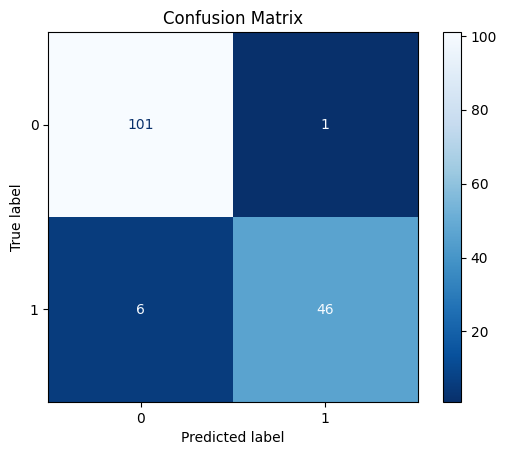

In [7]:
#opt logistic regression
eval={}
param_grid = {
    'C': [0.1, 1, 10],
    'max_iter': [100, 200, 500],
    'multi_class': ['auto', 'ovr', 'multinomial']
}
LR = LogisticRegression(random_state=42)
grid_search = GridSearchCV(LR, param_grid, cv=10)
grid_search.fit(X_train, y_train)
best_lr_model = grid_search.best_estimator_
print(grid_search.best_params_)

#perform cross-validation and get predicted labels for the training set
y_train_pred = cross_val_predict(best_lr_model, X_train, y_train, cv=10)
y_test_pred = best_lr_model.predict(X_test)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)



# recall is the most important since the goal here is to minimize false negatives (avoid predicting a malignant cancer as benign)
print("Training recall:", train_recall)
print("Test recall:", test_recall)

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

plot_confusion_matrix(best_lr_model, X_test, y_test, cmap='Blues_r')
plt.title("Confusion Matrix")
plt.show()


{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'solver': 'adam'}

The classifier accuracy score is 0.95

Training recall: 0.9090909090909091
Test recall: 0.8846153846153846
Confusion Matrix:
[[101   1]
 [  6  46]]


c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


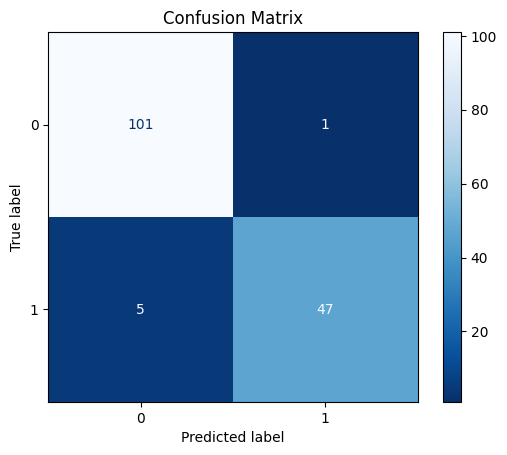

{'Train Recall': 0.9173553719008265,
 'Test Recall': 0.9038461538461539,
 'Test F1 Score': 0.9400000000000001}

In [8]:
#opt MLP
eval={}
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    
}
mlp = MLPClassifier(random_state=42, max_iter=2000)
grid_search = GridSearchCV(mlp, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_mlp_model = grid_search.best_estimator_
print(grid_search.best_params_)
classifier_score = best_mlp_model.score(X_test, y_test)
print('\nThe classifier accuracy score is {:03.2f}\n'.format(classifier_score))

# Perform cross-validation and get predicted labels for the training set
y_train_pred = cross_val_predict(best_mlp_model, X_train, y_train, cv=5)

y_test_pred = best_mlp_model.predict(X_test)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)



# recall is the most important metric since the goal here is to minimize false negatives (avoid predicting a malignant cancer as benign)
print("Training recall:", train_recall)
print("Test recall:", test_recall)

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

plot_confusion_matrix(best_mlp_model, X_test, y_test, cmap='Blues_r')
plt.title("Confusion Matrix")
plt.show()
evaluation_dict


In [9]:
'''#baseline
eval={}
param_grid = {
    'C': [0.1, 1, 10, 100],    
    'kernel': ['linear', 'rbf', 'poly'],  
    'degree': [2, 3, 4],               
    'gamma': ['scale', 'auto', 0.1, 1],  

}
svm_model = SVC(probability=True)
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_svm_model = grid_search.best_estimator_
print(grid_search.best_params_)

# Perform cross-validation and get predicted labels for the training set
y_train_pred = cross_val_predict(best_svm_model, X_train, y_train, cv=5)

y_test_pred = best_svm_model.predict(X_test)

# recall is the most important since the goal here is to minimize false negatives (avoid predicting a malignant cancer as benign)
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred)
evaluation_dict = {
    "Train Recall": train_recall,
    "Test Recall": test_recall,
    "Test F1 Score": test_f1_score
}

print(evaluation_dict)

conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

plot_confusion_matrix(best_svm_model, X_test, y_test, cmap='Blues_r')
plt.title("Confusion Matrix")
plt.show()
'''
